# API for Cognitive Clock Model V 

The script is for testing model from paper "Explainable artificial intelligence based Cognitive age clock"

In [221]:
import pandas as pd

In [222]:
df_subjects = pd.read_csv('dataset/subjects_info_test.tsv', sep='\t', index_col=0)
df_tests = pd.read_csv('dataset/tests_summary_v_test.tsv', sep='\t', index_col=0)

In [ ]:
import requests

URL_DOMAIN = 'https://scigames.ru'
BASE_URL = '/api/v1'
API_KEY = '26c7771b-8eb5-44bc-abc2-a446409e9c57'

def api_compute_dataset(df_tests, separator='\t'):
    data_csv = df_tests.to_csv(sep=separator, index=False)
    payload = {
        'data_csv': data_csv,
        'sep': separator
    }
    headers = {
        'X-API-KEY': API_KEY
    }
    
    api_url = URL_DOMAIN + BASE_URL + '/calculator/5.0:V/compute-dataset'
    try:
        response = requests.post(api_url, json=payload, headers=headers)
        response.raise_for_status()
        data = response.json()
        cognitive_ages = list(map(float, data['results']['cognitive_age']))
        return cognitive_ages
    except requests.exceptions.HTTPError as http_err:
        print(f'HTTP error occurred: {http_err.response.status_code} - {http_err.response.reason}')
    return None

cognitive_ages = api_compute_dataset(df_tests.loc[:200])

In [233]:
len(df_tests)

363

In [224]:
import numpy as np


def compute_cognitive_ages(df_tests, df_subjects):
    df_cage = pd.DataFrame(columns=['age', 'cage'], dtype=np.float64, index=df_subjects.index)
    chunk_size = 100
    for i in range(0, df_tests.shape[0], chunk_size):
        df_tests_batch = df_tests.iloc[i:i + chunk_size]
        ids = df_tests_batch.index
        df_subjects_batch = df_subjects.loc[ids]
        cognitive_ages = api_compute_dataset(df_tests_batch)
        
        df_cage.loc[ids, 'age'] = df_subjects_batch['age']
        df_cage.loc[ids, 'cage'] = cognitive_ages
    df_cage.dropna(inplace=True)
    return df_cage
df_cage = compute_cognitive_ages(df_tests, df_subjects)

In [229]:
from sklearn.metrics import mean_absolute_error
mae_test = mean_absolute_error(df_cage['age'], df_cage['cage'])
print(f'MAE test with bias correction: {mae_test:0.1f}')

MAE test with bias correction: 7.6


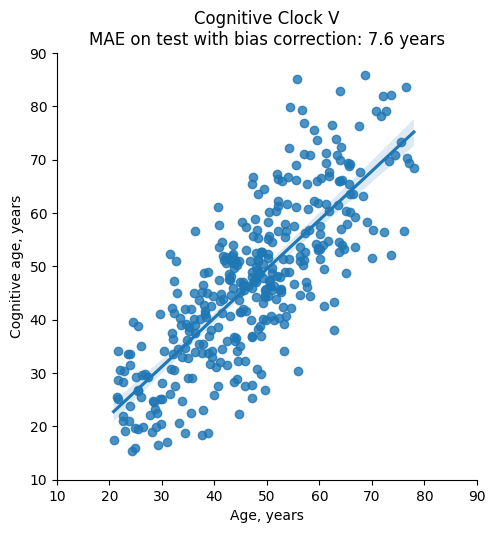

In [232]:
import seaborn as sns
sns.lmplot(data=df_cage, x='age', y='cage').set(
    ylim=[10, 90], xlim=[10, 90],
    xlabel='Age, years' ,
    ylabel='Cognitive age, years',
    title=f'Cognitive Clock V\nMAE on test with bias correction: {mae_test:0.1f} years'
)